In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from utils import process_w2v_data
from visual import show_w2v_word_embedding
import matplotlib.pyplot as plt

In [2]:
corpus = [
    # numbers
    "5 2 4 8 6 2 3 6 4",
    "4 8 5 6 9 5 5 6",
    "1 1 5 2 3 3 8",
    "3 6 9 6 8 7 4 6 3",
    "8 9 9 6 1 4 3 4",
    "1 0 2 0 2 1 3 3 3 3 3",
    "9 3 3 0 1 4 7 8",
    "9 9 8 5 6 7 1 2 3 0 1 0",

    # alphabets, expecting that 9 is close to letters
    "a t g q e h 9 u f",
    "e q y u o i p s",
    "q o 9 p l k j o k k o p",
    "h g y i u t t a e q",
    "i k d q r e 9 e a d",
    "o p d g 9 s a f g a",
    "i u y g h k l a s w",
    "o l u y a o g f s",
    "o p i u y g d a s j d l",
    "u k i l o 9 l j s",
    "y g i s h k j l f r f",
    "i o h n 9 9 d 9 f a 9",
]

#hyper parameters
emb_dim = 2
BATCH_SIZE = 10
LR = 0.001

In [3]:
class Skip_gram(nn.Module):
    def __init__(self, v_dim, emb_dim):
        super(Skip_gram, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings = v_dim,
            embedding_dim = emb_dim,
        )
        
        self.dense = nn.Linear(
            in_features=emb_dim,
            out_features=v_dim,
        )
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dense(x)
        log_probs = F.log_softmax(x, dim=0)
        return log_probs
        
        
data = process_w2v_data(corpus, skip_window=2, method="skip_gram")
skip_gram = Skip_gram(data.num_word, emb_dim)
loss_func = nn.NLLLoss()
opt = torch.optim.Adam(skip_gram.parameters(),lr=LR)

print(skip_gram)

all vocabularies sorted from more frequent to less frequent:
 ['9' '3' 'o' '6' 'a' '1' 'i' 'g' 's' '4' 'l' 'k' '8' 'u' '2' 'd' '5' 'y'
 'f' 'e' 'h' 'p' 'q' '0' 'j' '7' 't' 'r' 'w' 'n']
5 example pairs:
 [[16 14]
 [16  9]
 [14 16]
 [14  9]
 [14 12]]
Skip_gram(
  (embeddings): Embedding(30, 2)
  (dense): Linear(in_features=2, out_features=30, bias=True)
)


In [8]:
for i in range(10001):
    bx, by = data.sample(BATCH_SIZE)
    bx, by = torch.Tensor(bx).long(), torch.Tensor(by.reshape((-1))).long()
    y_head = skip_gram(bx)
    loss = loss_func(y_head, by)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i % 2000 == 0:
#         print(torch.argmax(y_head,1) == by)
        accuracy = float((torch.argmax(y_head,1) == by).sum())/BATCH_SIZE
        print("step: {} | loss: {}".format(i, loss), "  accuracy: ", accuracy)

step: 0 | loss: 1.447030782699585   accuracy:  0.2
step: 2000 | loss: 1.5890194177627563   accuracy:  0.2
step: 4000 | loss: 1.9249961376190186   accuracy:  0.0
step: 6000 | loss: 1.7325966358184814   accuracy:  0.0
step: 8000 | loss: 1.4372904300689697   accuracy:  0.3
step: 10000 | loss: 1.697511076927185   accuracy:  0.1


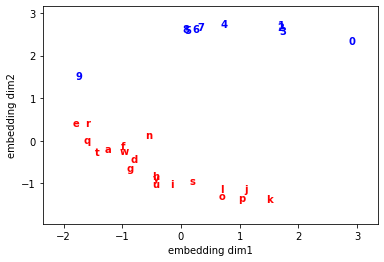

In [10]:
path = "./visual/results/skip_gram-torch.png"
word_emb = skip_gram.embeddings.weight
for i in range(data.num_word):
    c = "blue"
    try:
        int(data.i2v[i])
    except ValueError:
        c = "red"
    plt.text(word_emb[i, 0], word_emb[i, 1], s=data.i2v[i], color=c, weight="bold")
plt.xlim(word_emb.detach().numpy()[:, 0].min() - .5, word_emb.detach().numpy()[:, 0].max() + .5)
plt.ylim(word_emb.detach().numpy()[:, 1].min() - .5, word_emb.detach().numpy()[:, 1].max() + .5)
# plt.xticks(())
# plt.yticks(())
plt.xlabel("embedding dim1")
plt.ylabel("embedding dim2")
plt.savefig(path, dpi=300, format="png")
plt.show()